Visualize bleedthrough by mapping cell types to HOPXpos and EOMESpos AOIs:

Load libraries and data:

In [1]:
import sys,os
path = '/nfs/team283/aa16/KR_NAS/'
os.chdir(path)
sys.path.append(path)

In [2]:
import pickle
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
import isctools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


In [3]:
adata_wta = pickle.load(open("/nfs/team283/aa16/InSituCellTools/data/nanostringWTA_fetailBrain_AnnData.p", "rb" ))

In [4]:
adata_wta = adata_wta[adata_wta.obs['GoodQuality'],:]

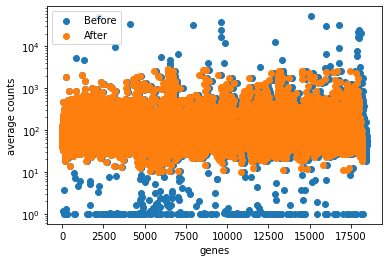

In [5]:
plt.scatter(range(np.shape(adata_wta.X)[1]), np.mean(adata_wta.X, axis = 0), label = 'Before')
plt.yscale('log')
plt.xlabel('genes')
plt.ylabel('average counts')

adata_wta = adata_wta[:, np.mean(adata_wta.X, axis = 0) < 3000]
adata_wta = adata_wta[:, np.mean(adata_wta.X, axis = 0) > 10]

plt.scatter(range(np.shape(adata_wta.X)[1]), np.mean(adata_wta.X, axis = 0), label = 'After')
plt.yscale('log')
plt.xlabel('genes')
plt.ylabel('average counts')
plt.legend()

In [6]:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

Make sure we have the same genes in reference and spatial data:

In [7]:
wta_genes = np.asarray(adata_wta.var_names)
common_genes = [wta_genes[i] for i in range(len(wta_genes)) if wta_genes[i] in meanExpression_sc.index] 
adata_wta = adata_wta[:,[adata_wta.var_names[i] in common_genes + ['NegProbe-WTX'] for i in range(len(adata_wta.var_names))]]
meanExpression_sc = meanExpression_sc.reindex(index = common_genes)

Fit each slide seperately:

In [8]:
slides = np.array(('00MR', '00MU', ('00MV', '00MV-2'), '00MW'))
adata_slide = list()
for j in range(len(slides)):
    adata_slide.append(adata_wta[[adata_wta.obs['slide'][i] in slides[j] for i in range(len(adata_wta.obs['slide']))]])
    print(np.shape(adata_slide[j]))

(66, 15077)
(74, 15077)
(52, 15077)
(63, 15077)


In [9]:
counts_geneProbes = list()
counts_negativeProbes = list()
counts_nuclei = list()

for i in range(len(slides)):
    counts_geneProbes.append(np.asarray(adata_slide[i][:,np.array(adata_slide[i].var != 'NegProbe-WTX').squeeze()].X))
    counts_negativeProbes.append(np.asarray(adata_slide[i][:,np.array(adata_slide[i].var =='NegProbe-WTX').squeeze()].X))
    counts_nuclei.append(np.asarray(adata_slide[i].obs['nuclei']).reshape(len(adata_slide[i].obs['nuclei']),1))

celltypes = meanExpression_sc.keys()
meanExpression_sc = np.asarray(meanExpression_sc)

In [10]:
celltypes

Index(['End', 'ExDp1', 'ExDp2', 'ExM', 'ExM-U', 'ExN', 'InCGE', 'InMGE', 'IP',
       'Mic', 'OPC', 'oRG', 'Per', 'PgG2M', 'PgS', 'vRG'],
      dtype='object')

In [11]:
models = list()
for i in range(len(slides)):
    models.append(isctools.ProbeCounts_CoLocationModel_NB_V1(
            cell_state_mat = meanExpression_sc,
            X_data = counts_geneProbes[i],
            Y_data = counts_negativeProbes[i],
            data_type='float32',
            n_iter=20000,
            learning_rate=0.001,
            fact_names=celltypes,
            gene_level_prior={'mean': 1/2, 'sd': 1/8, 'mean_var_ratio': 0.25},
            cell_number_prior={'cells_per_spot': counts_nuclei[i], 'factors_per_spot': 6, 'combs_per_spot': 50},
            cell_number_var_prior={'cells_mean_var_ratio': 0.1, 'factors_mean_var_ratio': 1, 'combs_mean_var_ratio': 1}))

We load previous results rather than fitting again:

In [12]:
models = pickle.load(open('0_publication_figures_scripts/models.p', 'rb'))

Make one large dataframe with cell numbers:

In [13]:
cellnumbers = pd.DataFrame(index = adata_wta.obs.index, columns = models[0].spot_factors_df.columns)
for j in range(len(slides)):
    cellnumbers.loc[[adata_wta.obs['slide'].iloc[i] in slides[j] for i in range(np.shape(adata_wta)[0])]] = np.array(models[j].spot_factors_df)

In [14]:
cellnumbers.loc[[adata_wta.obs['slide'].iloc[i] in slides[j] for i in range(np.shape(adata_wta)[0])]]

,mean_spot_factorsEnd,mean_spot_factorsExDp1,mean_spot_factorsExDp2,mean_spot_factorsExM,mean_spot_factorsExM-U,mean_spot_factorsExN,mean_spot_factorsInCGE,mean_spot_factorsInMGE,mean_spot_factorsIP,mean_spot_factorsMic,mean_spot_factorsOPC,mean_spot_factorsoRG,mean_spot_factorsPer,mean_spot_factorsPgG2M,mean_spot_factorsPgS,mean_spot_factorsvRG
HCA_F_BRA8739274,18.8436,2.52055,1.65815,195.807,3.85931,1376.97,142.14,65.106,429.819,36.372,7.82687,318.059,17.1534,132.004,302.901,35.6434
HCA_F_BRA8739275,4.31827,1.12447,0.595142,15.5052,0.890135,185.431,18.7817,9.3733,22.0181,5.33466,0.824047,156.127,1.73311,26.4732,27.9483,29.8114
HCA_F_BRA8739276,0.0279166,0.241484,0.1557,0.238369,0.336404,0.46559,24.1593,6.6729,102.581,0.0912881,0.0454245,0.132518,0.0213739,8.63313,23.4642,43.7559
HCA_F_BRA8739277,0.354528,0.906339,0.400617,49.0967,1.63477,185.491,19.0842,6.24582,240.594,5.03472,1.00321,18.0501,0.408171,77.5075,162.806,0.999833
HCA_F_BRA8739278,2.63124,6.00182,2.2537,556.418,3.71183,893.604,15.5893,4.398,137.532,8.65691,10.4856,189.893,2.03865,88.803,210.49,2.64897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HCA_F_BRA8739353,14.4304,4.10533,1.41429,86.6437,6.59068,1006.55,140.44,47.8774,265.028,22.3182,6.63261,83.0346,10.6653,61.8607,132.748,103.532
HCA_F_BRA8739354,5.49723,1.70422,0.741178,3.34086,3.45855,954.366,648.765,230.079,557.015,4.52981,1.90087,10.1218,3.81802,59.5092,72.5537,121.963
HCA_F_BRA8739355,22.5051,32.3084,3.34651,501.882,8.51058,580.557,39.7303,14.3373,84.4047,40.9343,33.851,16.1995,16.4924,34.0652,79.3656,42.095
HCA_F_BRA8739356,14.3401,3.49619,1.62889,54.2537,11.2249,810.527,100.434,34.1763,203.183,17.3983,6.19254,43.213,9.83674,48.4824,103.241,46.3924


In [15]:
cellnumbers

,mean_spot_factorsEnd,mean_spot_factorsExDp1,mean_spot_factorsExDp2,mean_spot_factorsExM,mean_spot_factorsExM-U,mean_spot_factorsExN,mean_spot_factorsInCGE,mean_spot_factorsInMGE,mean_spot_factorsIP,mean_spot_factorsMic,mean_spot_factorsOPC,mean_spot_factorsoRG,mean_spot_factorsPer,mean_spot_factorsPgG2M,mean_spot_factorsPgS,mean_spot_factorsvRG
HCA_F_BRA8739082,1.14971,2.12172,8.13859,0.998412,1.44337,1.21512,15.7357,1.27878,65.2596,0.718281,6.22264,338.512,2.77875,26.4055,22.1001,386.207
HCA_F_BRA8739083,8.19868,3.52621,9.12277,39.6257,12.173,359.198,234.663,24.3111,283.015,9.13515,1.10719,195.42,3.33929,31.3769,72.2424,15.8347
HCA_F_BRA8739084,8.08213,2.32098,5.78036,11.1269,18.4145,732.576,160.324,22.7857,432.455,3.38521,0.999815,298.472,3.34367,45.4485,121.8,39.6226
HCA_F_BRA8739085,2.84048,3.14378,42.5207,160.232,21.6398,386.271,25.7598,2.25786,92.7018,0.436294,0.696703,57.8014,2.52293,15.1749,78.2526,4.0491
HCA_F_BRA8739086,10.6618,8.71481,2.35587,7.13911,4.11317,203.341,596.791,69.8298,310.328,16.7128,1.18023,190.746,4.65611,19.6539,13.8674,85.1268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HCA_F_BRA8739354,5.49723,1.70422,0.741178,3.34086,3.45855,954.366,648.765,230.079,557.015,4.52981,1.90087,10.1218,3.81802,59.5092,72.5537,121.963
HCA_F_BRA8739355,22.5051,32.3084,3.34651,501.882,8.51058,580.557,39.7303,14.3373,84.4047,40.9343,33.851,16.1995,16.4924,34.0652,79.3656,42.095
HCA_F_BRA8739356,14.3401,3.49619,1.62889,54.2537,11.2249,810.527,100.434,34.1763,203.183,17.3983,6.19254,43.213,9.83674,48.4824,103.241,46.3924
HCA_F_BRA8739357,14.7967,8.56184,0.938851,6.93186,14.2144,592.121,35.2781,10.7508,196.483,21.9726,6.99262,24.0744,10.5832,38.9877,97.8009,85.6708


Overview plot of the cell locations in the 19pcw and 14pcw samples:

We use the colour code that we use for all figures:

In [16]:
colourCode = pickle.load(open('../KR_NAS/0_publication_figures_scripts/celltypesColourCode.p',  "rb"))
roiRelations = pickle.load(open('../KR_NAS/data/ROI_relations.p', 'rb'))

In [17]:
roiRelations

,Slide,Radial_position,VCDepth,Background,HOPXpos,EOMESpos,ParallelROI,Ring
0,00MU,1,0.028892,126,111,103,107,118
1,00MU,1,0.094703,156,141,134,122,148
2,00MU,1,0.205457,96,172,164,137,180
3,00MU,1,0.303371,127,112,104,152,119
4,00MU,1,0.382022,157,142,135,160,149
5,00MU,3,0.028892,94,170,162,107,178
6,00MU,3,0.094703,125,110,102,122,117
7,00MU,3,0.205457,155,140,133,137,147
8,00MU,3,0.303371,95,171,163,152,179
9,00MU,3,0.382022,97,173,165,160,181


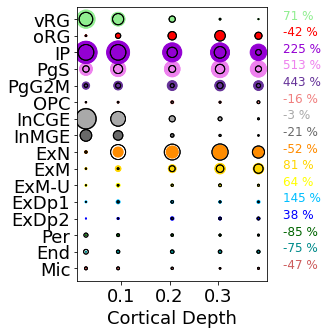

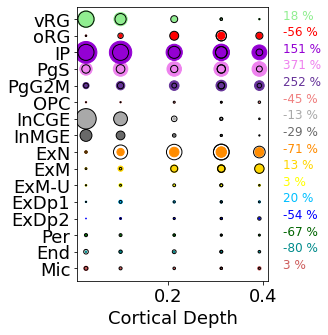

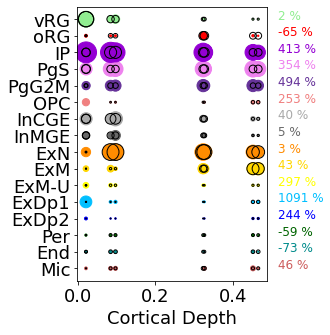

In [18]:
slides = np.array(('00MU', '00MV', '00MW'))

# Reorder cell types:
cellorder = np.array(['vRG','oRG', 'IP', 'PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN','ExM','ExM-U', 'ExDp1', 'ExDp2', 'Per', 'End', 'Mic'])
neworder = np.flipud([np.where(models[0].fact_names == cellorder[j])[0][0] for j in range(len(cellorder))])

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 0.25
power = 0.75

labels = ('19pcw_1', '19pcw_2', '14pcw_1')

for i in range(len(slides)):
    
    eomes_index = list(roiRelations['EOMESpos'].loc[roiRelations['Slide'] == slides[i]])
    geometric_index = list(roiRelations['ParallelROI'].loc[roiRelations['Slide'] == slides[i]])
    
    roi_dimension = np.array(adata_wta.obs['roi_dimension'].iloc[:,0])
    
    celltypesForPlot = np.repeat(models[i].fact_names[neworder],len(eomes_index))
    vcForPlot = np.array([adata_wta.obs['VCDepth'].iloc[eomes_index] for j in range(len(models[i].fact_names))]).flatten()
    countsForPlot = np.array([cellnumbers.iloc[:,j].iloc[eomes_index]/roi_dimension[eomes_index]*10**6
                              for j in neworder])
    coloursForPlot = np.array(colourCode.loc[np.array((celltypesForPlot)),'Colour'])
    
    countsForPlot_1 = np.array([cellnumbers.iloc[:,j].iloc[geometric_index]/roi_dimension[geometric_index]*10**6
                              for j in neworder])
    
    plt.figure(figsize = (5,5))

    plt.scatter(vcForPlot, celltypesForPlot, s=np.float64(((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power),
                c= coloursForPlot, edgecolors='face')

    plt.scatter(vcForPlot, celltypesForPlot, s=np.float64(((-np.amin(countsForPlot_1*scaling) + countsForPlot_1*scaling))**power),
        c= 'None', edgecolors = 'black')
#     plt.scatter(vcForPlot, celltypesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
#                 c= 'black')
    
    plt.xlabel('Cortical Depth')
    
    _, idx = np.unique(coloursForPlot, return_index=True)
    textColours = np.flipud(coloursForPlot[np.sort(idx)])
    for j in range(len(cellorder)):
        plt.text(np.max(vcForPlot)+0.05, cellorder[j],
                 str(np.flipud(np.round(np.float64(-1*(1-np.mean(countsForPlot, axis = 1)/np.mean(countsForPlot_1, axis = 1))*100),0))[j])[:-2] + ' %',
                 fontsize=20, c = textColours[j], size = 12)
    
#     # make a legend:
#     pws = [0,0,100,500,1000,3000,6000,10000, 30000]
#     for pw in pws:
#         plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))
#     h, l = plt.gca().get_legend_handles_labels()
#     lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Density ($cells/mm^2$)", borderpad=1, 
#                 frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    #plt.subplots_adjust(left = 0.25)
    plt.savefig('0_publication_figures/Figure4_CelltypeEnrichment_EOMESpos' + labels[i] + '.pdf')
    plt.show()

Same for HOPXpos population:

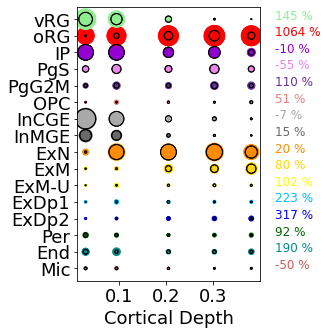

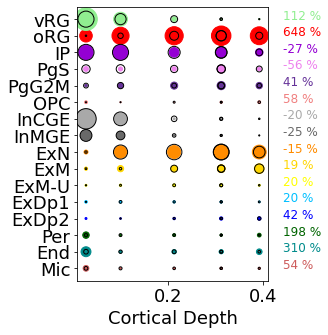

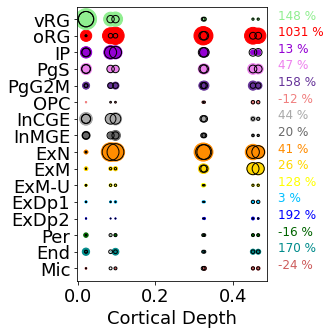

In [19]:
slides = np.array(('00MU', '00MV', '00MW'))

# Reorder cell types:
cellorder = np.array(['vRG','oRG', 'IP', 'PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN','ExM','ExM-U', 'ExDp1', 'ExDp2', 'Per', 'End', 'Mic'])
neworder = np.flipud([np.where(models[0].fact_names == cellorder[j])[0][0] for j in range(len(cellorder))])

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 0.25
power = 0.75

labels = ('19pcw_1', '19pcw_2', '14pcw_1')

for i in range(len(slides)):
    
    eomes_index = list(roiRelations['HOPXpos'].loc[roiRelations['Slide'] == slides[i]])
    geometric_index = list(roiRelations['ParallelROI'].loc[roiRelations['Slide'] == slides[i]])
    
    roi_dimension = np.array(adata_wta.obs['roi_dimension'].iloc[:,0])
    
    celltypesForPlot = np.repeat(models[i].fact_names[neworder],len(eomes_index))
    vcForPlot = np.array([adata_wta.obs['VCDepth'].iloc[eomes_index] for j in range(len(models[i].fact_names))]).flatten()
    countsForPlot = np.array([cellnumbers.iloc[:,j].iloc[eomes_index]/roi_dimension[eomes_index]*10**6
                              for j in neworder])
    coloursForPlot = np.array(colourCode.loc[np.array((celltypesForPlot)),'Colour'])
    
    countsForPlot_1 = np.array([cellnumbers.iloc[:,j].iloc[geometric_index]/roi_dimension[geometric_index]*10**6
                              for j in neworder])
    
    plt.figure(figsize = (5,5))

    plt.scatter(vcForPlot, celltypesForPlot, s=np.float64(((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power),
                c= coloursForPlot, edgecolors='face')

    plt.scatter(vcForPlot, celltypesForPlot, s=np.float64(((-np.amin(countsForPlot_1*scaling) + countsForPlot_1*scaling))**power),
        c= 'None', edgecolors = 'black')
#     plt.scatter(vcForPlot, celltypesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
#                 c= 'black')
    
    plt.xlabel('Cortical Depth')
    
    _, idx = np.unique(coloursForPlot, return_index=True)
    textColours = np.flipud(coloursForPlot[np.sort(idx)])
    for j in range(len(cellorder)):
        plt.text(np.max(vcForPlot)+0.05, cellorder[j],
                 str(np.flipud(np.round(np.float64(-1*(1-np.mean(countsForPlot, axis = 1)/np.mean(countsForPlot_1, axis = 1))*100),0))[j])[:-2] + ' %',
                 fontsize=20, c = textColours[j], size = 12)
    
#     # make a legend:
#     pws = [0,0,100,500,1000,3000,6000,10000, 30000]
#     for pw in pws:
#         plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))
#     h, l = plt.gca().get_legend_handles_labels()
#     lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Density ($cells/mm^2$)", borderpad=1, 
#                 frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    #plt.subplots_adjust(left = 0.25)
    plt.savefig('0_publication_figures/Figure4_CelltypeEnrichment_HOPXpos' + labels[i] + '.pdf')
    plt.show()

Instead make a different plot that shows average cell density in bulk ROIs, HOPXpos AOIs, EOMESpos AOIs, reference rings and background and uses colour to denote an increase/decrease:

Get average cell density in each type of ROI, as well as increase compared to bulkROI:

In [20]:
# Reorder cell types:
cellorder = np.array(['vRG','oRG', 'IP', 'PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN','ExM','ExM-U', 'ExDp1', 'ExDp2', 'Per', 'End', 'Mic'])
neworder = np.flipud([np.where(models[0].fact_names == cellorder[j])[0][0] for j in range(len(cellorder))])

roi_dimension = np.array(adata_wta.obs['roi_dimension'].iloc[:,0])

i = 0

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.


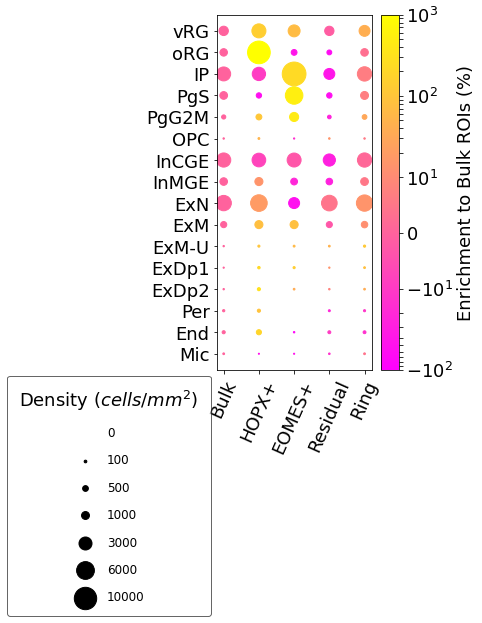

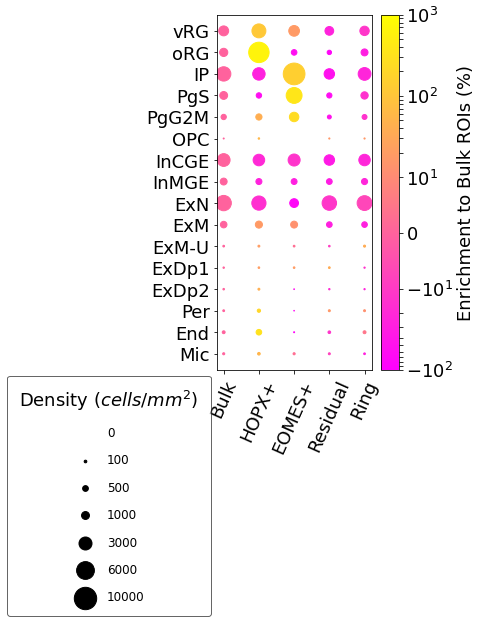

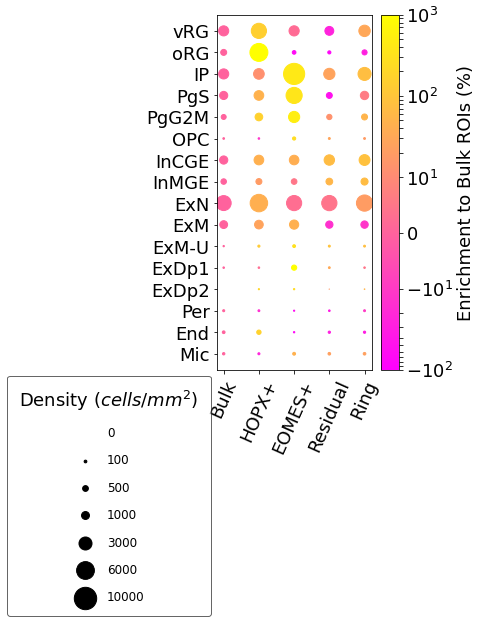

In [21]:
import matplotlib.colors as colors

slides = np.array(('00MU', '00MV', '00MW'))

# Reorder cell types:
cellorder = np.array(['vRG','oRG', 'IP', 'PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN','ExM','ExM-U', 'ExDp1', 'ExDp2', 'Per', 'End', 'Mic'])
neworder = np.flipud([np.where(models[0].fact_names == cellorder[j])[0][0] for j in range(len(cellorder))])

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 0.1
power = 0.9

labels = ('19pcw_1', '19pcw_2', '14pcw_1')

for i in range(len(slides)):

    roi_dimension = np.array(adata_wta.obs['roi_dimension'].iloc[:,0])
    
    eomes_index = list(roiRelations['EOMESpos'].loc[roiRelations['Slide'] == slides[i]])
    hopx_index = list(roiRelations['HOPXpos'].loc[roiRelations['Slide'] == slides[i]])
    np.delete(hopx_index, np.argmin(adata_wta.obs.iloc[hopx_index]['VCDepth']))
    geometric_index = list(roiRelations['ParallelROI'].loc[roiRelations['Slide'] == slides[i]])
    residual_index = list(roiRelations['Background'].loc[roiRelations['Slide'] == slides[i]])
    ring_index = list(roiRelations['Ring'].loc[roiRelations['Slide'] == slides[i]])

    all_index = list([geometric_index, hopx_index, eomes_index, residual_index, ring_index])

    countsForPlot = np.array([[np.mean(cellnumbers.iloc[:,j].iloc[all_index[k]]/roi_dimension[all_index[k]]*10**6)
                                  for j in neworder] for k in range(len(all_index))]).T
    
    enrichmentForPlot = (-1*(1-np.array([countsForPlot[:,i]/countsForPlot[:,0] for i in range(5)]))*100).T
    
    celltypesForPlot = np.repeat(models[i].fact_names[neworder],5)
    vcForPlot = np.array([('Bulk', 'HOPX+', 'EOMES+','Residual', 'Ring')
                          for j in range(len(models[i].fact_names))]).flatten()
    
    fig = plt.figure(figsize = (6.75,9))

    mesh = plt.scatter(vcForPlot, celltypesForPlot, s=np.float64(((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power),
                c= enrichmentForPlot, edgecolors='face', cmap = 'spring',
                       norm=colors.SymLogNorm(linthresh=10, linscale=1, vmin=-100, vmax=1000))
    cbar = fig.colorbar(mesh)
    cbar.set_label('Enrichment to Bulk ROIs (%)')
    
    # make a legend:
    pws = [0,0,100,500,1000,3000,6000,10000]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))
    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Density ($cells/mm^2$)", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(0, 0))
    
    plt.tight_layout()
    plt.xticks(rotation=66)
    
    #plt.subplots_adjust(left = 0.25)
    plt.savefig('0_publication_figures/Figure4_CelltypeEnrichment_Draft4_'+ labels[i] +'.pdf',
                bbox_inches='tight')
    plt.show()

Make the figure horizontal instead:

8


/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.


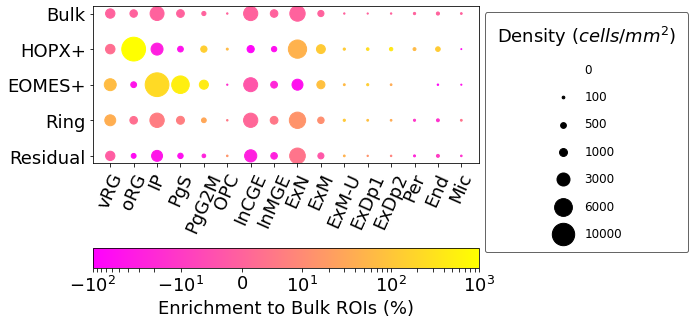

5


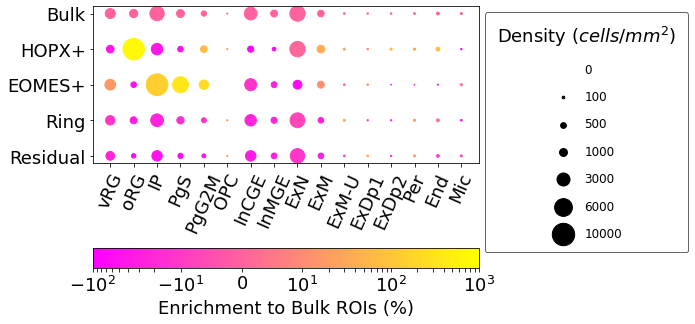

6


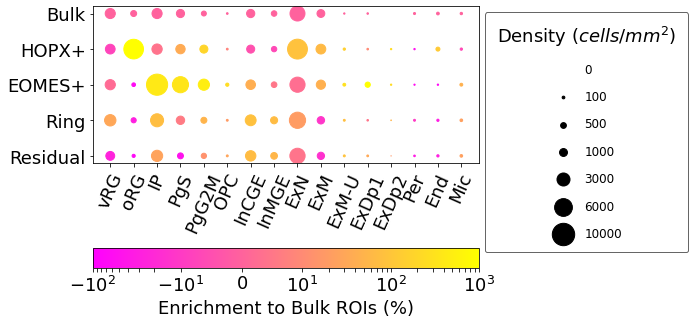

In [44]:
import matplotlib.colors as colors

slides = np.array(('00MU', '00MV', '00MW'))

# Reorder cell types:
cellorder = np.array(['vRG','oRG', 'IP', 'PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN','ExM','ExM-U', 'ExDp1', 'ExDp2', 'Per', 'End', 'Mic'])
neworder = [np.where(models[0].fact_names == cellorder[j])[0][0] for j in range(len(cellorder))]

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 0.1
power = 0.9

labels = ('19pcw_1', '19pcw_2', '14pcw_1')

for i in range(len(slides)):

    roi_dimension = np.array(adata_wta.obs['roi_dimension'].iloc[:,0])
    
    eomes_index = list(roiRelations['EOMESpos'].loc[roiRelations['Slide'] == slides[i]])
    hopx_index = list(roiRelations['HOPXpos'].loc[roiRelations['Slide'] == slides[i]])
    hopx_index = np.delete(hopx_index, np.where(adata_wta.obs.iloc[hopx_index]['VCDepth'] < 0.05)[0])
    geometric_index = list(roiRelations['ParallelROI'].loc[roiRelations['Slide'] == slides[i]])
    residual_index = list(roiRelations['Background'].loc[roiRelations['Slide'] == slides[i]])
    ring_index = list(roiRelations['Ring'].loc[roiRelations['Slide'] == slides[i]])
    
    print(len(hopx_index))
    
    all_index = np.flipud(list([geometric_index, hopx_index, eomes_index, ring_index, residual_index]))

    countsForPlot = np.array([[np.mean(cellnumbers.iloc[:,j].iloc[all_index[k]]/roi_dimension[all_index[k]]*10**6)
                                  for j in neworder] for k in range(len(all_index))]).T
    
    enrichmentForPlot = (-1*(1-np.array([countsForPlot[:,i]/countsForPlot[:,4] for i in range(5)]))*100).T
    
    vcForPlot = np.flipud(np.array([('Bulk', 'HOPX+', 'EOMES+','Ring','Residual')
                          for j in range(len(models[i].fact_names))]).flatten())
    celltypesForPlot = np.repeat(models[i].fact_names[neworder],5)
    
    fig = plt.figure(figsize = (10,5))

    mesh = plt.scatter(celltypesForPlot, vcForPlot, s=np.float64(((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power),
                c= enrichmentForPlot, edgecolors='face', cmap = 'spring',
                       norm=colors.SymLogNorm(linthresh=10, linscale=1, vmin=-100, vmax=1000))
    cbar = fig.colorbar(mesh, orientation="horizontal", pad = 0.3)
    cbar.set_label('Enrichment to Bulk ROIs (%)')
    
    # make a legend:
    pws = [0,0,100,500,1000,3000,6000,10000]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))
    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Density ($cells/mm^2$)", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.xticks(rotation=66)
    
    #plt.subplots_adjust(left = 0.25)
    plt.savefig('0_publication_figures/Figure4_CelltypeEnrichment_Draft5_'+ labels[i] +'.pdf',
                bbox_inches='tight')
    plt.show()
    
    # Also save as supplementary table:
    
    tab = pd.DataFrame(countsForPlot,
                   columns = np.flipud(('Bulk', 'HOPX+', 'EOMES+', 'Ring', 'Residual')),
                   index = ('vRG', 'oRG', 'IP','PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN', 'ExM', 'ExM-U',
                             'ExDp1', 'ExDp2','Per','End','Mic'))
    tab.to_csv('0_publication_tables/CelltypeDensity_AcrossAOIs_'+ labels[i] +'.csv') 

In [31]:
tab = pd.DataFrame(countsForPlot,
                   columns = np.flipud(('Bulk', 'HOPX+', 'EOMES+', 'Ring', 'Residual')),
                   index = ('vRG', 'oRG', 'IP','PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN', 'ExM', 'ExM-U',
                             'ExDp1', 'ExDp2','Per','End','Mic'))
tab 

,Residual,Ring,EOMES+,HOPX+,Bulk
vRG,1286.778596,2241.876603,1748.354104,4238.306244,1710.978738
oRG,135.576110,385.095895,187.797016,6139.042646,542.662671
IP,2169.331057,3014.350680,8827.415790,1937.255529,1720.834218
PgS,530.050797,1131.626730,4839.194992,1565.088497,1066.164803
PgG2M,409.935554,543.240500,2147.726846,933.073792,361.281168
OPC,50.973883,47.598629,140.587726,34.950086,39.847869
InCGE,1837.414647,2012.671492,1519.755803,1561.847565,1084.567713
InMGE,701.109333,778.231928,475.881828,542.273689,453.674790
ExN,4275.163337,4901.631091,4214.743230,5786.910573,4094.377663
ExM,835.743470,861.921910,1395.896323,1227.687318,975.549291


In [34]:
len(hopx_index)

8

HCA_F_BRA8739289    0.021415
HCA_F_BRA8739338    0.097559
HCA_F_BRA8739307    0.323609
HCA_F_BRA8739339    0.452101
HCA_F_BRA8739284    0.021784
HCA_F_BRA8739316    0.084958
HCA_F_BRA8739285    0.326762
HCA_F_BRA8739317    0.465636
Name: VCDepth, dtype: float64